In [1]:
### Dogs vs Cats, not cleaned yet

In [2]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently operating on {device}')
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from torchsummary import summary


Currently operating on cuda


In [4]:
#Specify the device again

print(device)

cuda


In [4]:
# If operating in Colab, run the cell for extraction of data.
!pip install -q kaggle
from google.colab import files
files.upload() #Use your Kaggle Token API from the downloads

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d tongpython/cat-and-dog



Saving kaggle.json to kaggle.json
kaggle.json
 98% 214M/218M [00:02<00:00, 103MB/s] 
100% 218M/218M [00:02<00:00, 110MB/s]


In [5]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [6]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [23]:
from torch.utils.data import DataLoader, Dataset
from random import shuffle, seed 
seed(10)
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
  def __len__(self):
    return len(self.fpaths)
  def __getitem__ (self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

    

In [24]:
data = cats_dogs(train_data_dir)

tensor([1.], device='cuda:0')


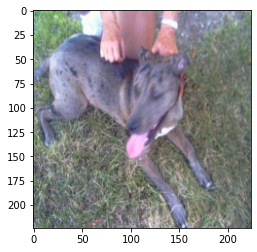

In [25]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [35]:
def conv_layer(ni,no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni,no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )
def get_model():
  model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,1),
      nn.Sigmoid(),
      ).to(device)
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [37]:
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [38]:
def get_data():
  train = cats_dogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

  val = cats_dogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)

  return trn_dl, val_dl

def train_batch(x,y,model,opt,loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

@torch.no_grad()
def accuracy(x,y,model):
  prediction = model(x)
  is_correct = (prediction>0.5) == y
  return is_correct.cpu().numpy().tolist()
@torch.no_grad()
def val_loss(x,y,model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [39]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [41]:
train_losses, train_accuracies = [],[]
val_losses, val_accuracies = [],[]

for epoch in range(10):
  print(f'Completing Epoch: {epoch}')
  train_epoch_losses, train_epoch_accuracies = [],[]
  val_epoch_accuracies = []

  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    batch_loss = train_batch(x,y,model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  
  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    is_correct = accuracy(x,y,model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x,y = batch
    val_is_correct = accuracy(x,y,model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)

Completing Epoch: 0
Completing Epoch: 1
Completing Epoch: 2
Completing Epoch: 3
Completing Epoch: 4
Completing Epoch: 5
Completing Epoch: 6
Completing Epoch: 7
Completing Epoch: 8
Completing Epoch: 9


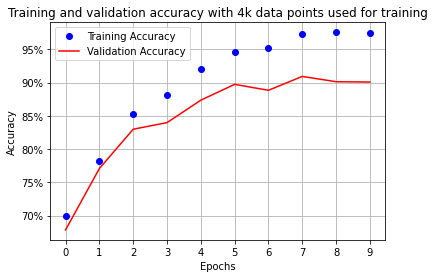

In [44]:
epochs = np.arange(10)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and validation accuracy with 4k data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [45]:
torch.save(model.state_dict(), '/content/catsdogs.pth')

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [92]:
def predict_custom_img(PATH):
  img = cv2.imread(PATH)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img1 = cv2.resize(img, (224,224))
  img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
  img1 = torch.unsqueeze(img1,0)
  img1 = img1.permute(0,2,1,3)
  print(img1.shape)
  prediction = model(img1)
  if prediction < 0.5:
    a = str(f'This is a cat {prediction}')
  else:
    a = str(f'This is a dog {prediction}')
  plt.imshow(img)
  plt.title(a)
  return img1

torch.Size([1, 3, 224, 224])


tensor([[[[0.0863, 0.0824, 0.0784,  ..., 0.1294, 0.1490, 0.1529],
          [0.0824, 0.0824, 0.0784,  ..., 0.1255, 0.1412, 0.1490],
          [0.0784, 0.0784, 0.0745,  ..., 0.1176, 0.1373, 0.1412],
          ...,
          [0.7216, 0.7255, 0.7294,  ..., 0.7686, 0.7686, 0.7686],
          [0.7216, 0.7255, 0.7294,  ..., 0.7647, 0.7686, 0.7686],
          [0.7216, 0.7216, 0.7255,  ..., 0.7647, 0.7686, 0.7686]],

         [[0.1686, 0.1647, 0.1647,  ..., 0.2471, 0.2627, 0.2824],
          [0.1647, 0.1686, 0.1647,  ..., 0.2431, 0.2588, 0.2784],
          [0.1647, 0.1647, 0.1608,  ..., 0.2392, 0.2549, 0.2706],
          ...,
          [0.6863, 0.6863, 0.6902,  ..., 0.7412, 0.7373, 0.7373],
          [0.6863, 0.6902, 0.6941,  ..., 0.7373, 0.7333, 0.7333],
          [0.6863, 0.6863, 0.6902,  ..., 0.7373, 0.7333, 0.7333]],

         [[0.1333, 0.1255, 0.1176,  ..., 0.1451, 0.1529, 0.1608],
          [0.1294, 0.1216, 0.1176,  ..., 0.1412, 0.1490, 0.1569],
          [0.1216, 0.1176, 0.1098,  ..., 0

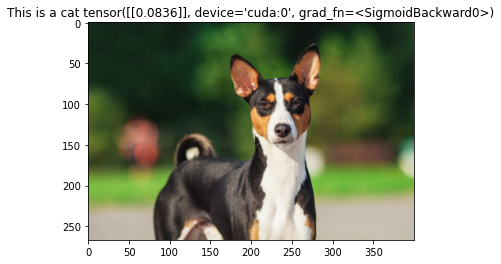

In [122]:
predict_custom_img('/content/basenji.jpg')

In [101]:
def predict_custom_img_features(PATH):
  img = cv2.imread(PATH)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img1 = cv2.resize(img, (224,224))
  img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
  img1 = torch.squeeze(img1,0)
  #img1 = img1.permute(0,2,1,3)
  print(img1.shape)
  #prediction = model(img1)
  #if prediction < 0.5:
    #a = str(f'This is a cat {prediction}')
  #else:
    #a = str(f'This is a dog {prediction}')
  #plt.imshow(img)
  #plt.title(a)
  return img1

In [108]:
im = predict_custom_img_features('/content/puppy.jpg')
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

torch.Size([3, 224, 224])


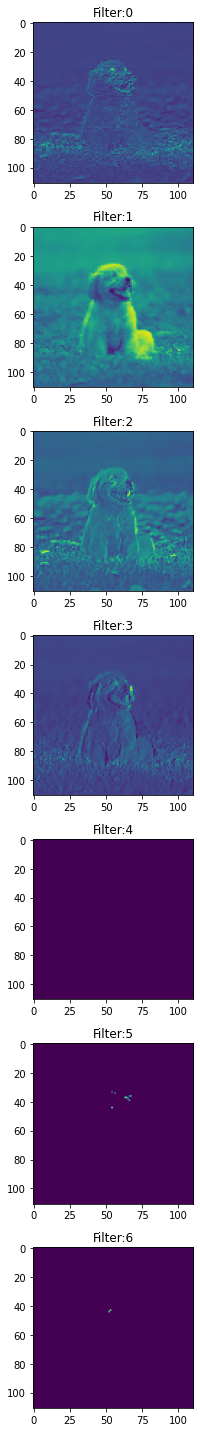

In [109]:
fig, ax = plt.subplots(7,1, figsize = (20,20))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter:'+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

torch.Size([3, 224, 224])


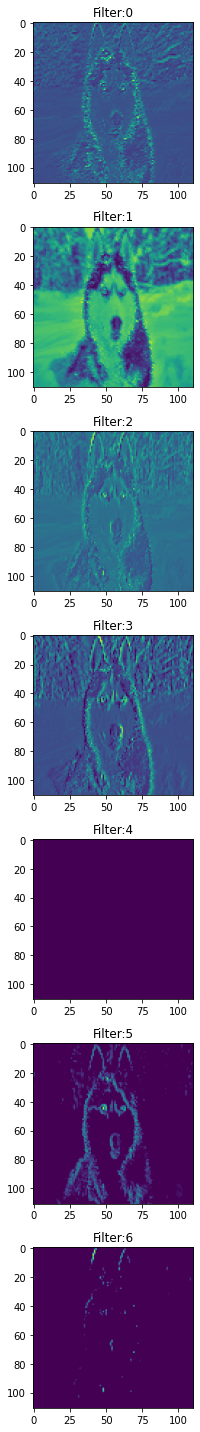

In [118]:
im = predict_custom_img_features('/content/husky.jpg')
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

fig, ax = plt.subplots(7,1, figsize = (20,20))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter:'+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

torch.Size([3, 224, 224])


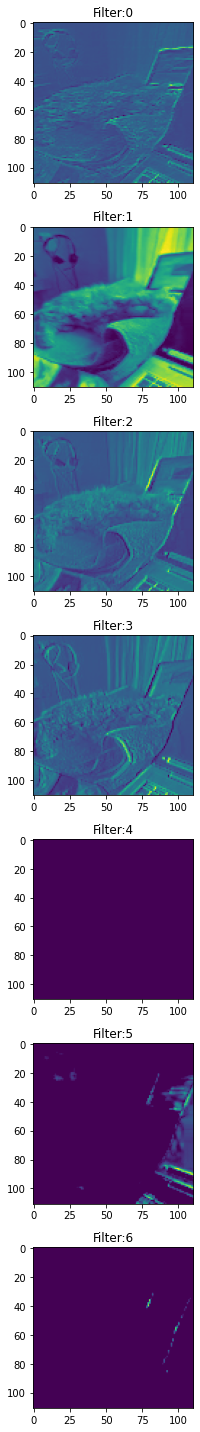

In [114]:
#Cat
im = predict_custom_img_features('/content/phoebe.jpg')
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()
fig, ax = plt.subplots(7,1, figsize = (20,20))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter:'+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
  #axis.imshow(cv2.imread('/content/phoebe.jpg'))
plt.tight_layout()
plt.show()